
# IBM Quantum vs T4 GPU Arena - Iris Dataset
*Babycommando, 2024*

This project aims to compare the performance of the **quantum-enhanced feature space** model using Qiskit on a real quantum backend using 100 qubits - with a classical neural network model running on a GPU using TensorFlow and Keras using a simple neural network with two hidden layers (64 and 32 neurons).

The quantum-enhanced feature space model maps data into a high-dimensional space using quantum circuits, potentially capturing complex patterns that classical models might miss. By utilizing 100 qubits, this approach explores the capabilities of quantum processors to handle more intricate feature representations.

This code includes steps to save and load your IBM Quantum Platform account, prepare the Iris dataset, train and evaluate both models, and visualize the results.




**⚠️ Important**:
- **Make sure to run this instance with a GPU.**
- **Grab yout IBM Quantum Platform at https://quantum.ibm.com/**
- At the **Setup IBM Qiskit Key** step, make sure to change **"< YOUR_IBM_QUANTUM_API_TOKEN >"** with your real key.

In [ ]:
!pip install qiskit qiskit-machine-learning qiskit-aer qiskit-ibm-runtime tensorflow

In [ ]:
# imports
# measurement tools
import time
import numpy as np
import matplotlib.pyplot as plt

# IBM Qiskit for quantum deep learning on GPU
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute

# TensorFlow  / Keras for deep learning on GPU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Iris dataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Setup IBM Qiskit key

In [ ]:
# Save your IBM Quantum account (Replace <YOUR_IBM_QUANTUM_API_TOKEN> with your actual token)
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="<YOUR_IBM_QUANTUM_API_TOKEN>",
    overwrite=True
    )

# Load the saved account
service = QiskitRuntimeService(channel="ibm_quantum")


Load the Iris dataset

In [ ]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Use only two classes for binary classification (Setosa and Versicolor)
X = X[y != 2]
y = y[y != 2]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Define Quantum Kernel using primitives with 100 qubits

In [ ]:
# Increase the feature dimension to 100
feature_dimension = 100

# Define the feature map with increased feature dimension
feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement="linear")

# Define the sampler
sampler = Sampler()

# Define the fidelity
fidelity = ComputeUncompute(sampler=sampler)

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)


Simulating
This step trains and evaluates the model with the IBM Qiskit simulator, good practice before running on an actual quantum processing unit.

In [ ]:
# Set up the simulator
simulator = AerSimulator()

# Define Quantum Kernel using the simulator
fidelity = ComputeUncompute(sampler=sampler)
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Train QSVC model and measure time
start_time = time.time()
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train)
qsvc_score_sim = qsvc.score(X_test, y_test)
quantum_time_sim = time.time() - start_time

print(f"QSVC classification test score with simulator: {qsvc_score_sim}")
print(f"QSVC training time with simulator: {quantum_time_sim} seconds")


QSVC classification test score with simulator: 0.6
QSVC training time with simulator: 28.691285371780396 seconds


Real Quantum Backend

In [ ]:
# Choose a real backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=100)

# Use a Session to run the QSVC on the real backend
with Session(service=service, backend=backend) as session:
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    # Train QSVC model and measure time
    start_time = time.time()
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train)
    qsvc_score_real = qsvc.score(X_test, y_test)
    quantum_time_real = time.time() - start_time

    print(f"QSVC classification test score with real quantum backend: {qsvc_score_real}")
    print(f"QSVC training time with real quantum backend: {quantum_time_real} seconds")


QSVC classification test score with real quantum backend: 0.6
QSVC training time with real quantum backend: 27.469263315200806 seconds


---
GPU

In [ ]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Define the classical neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and measure time
start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
classical_time = time.time() - start_time

# Evaluate the model
_, classical_score = model.evaluate(X_test, y_test, verbose=0)

print(f"Classical neural network test score: {classical_score}")
print(f"Classical neural network training time: {classical_time} seconds")


Classical neural network test score: 1.0
Classical neural network training time: 4.302614688873291 seconds


Arena Final Results

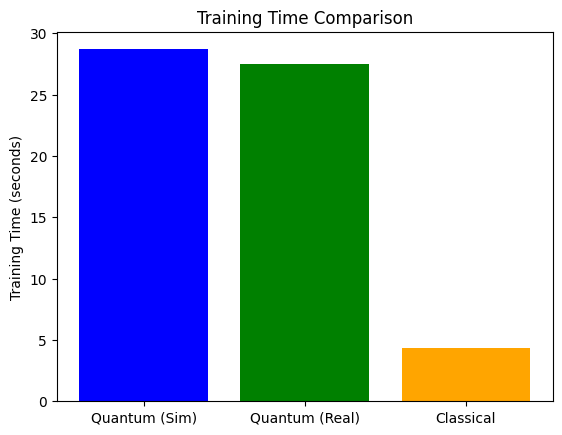

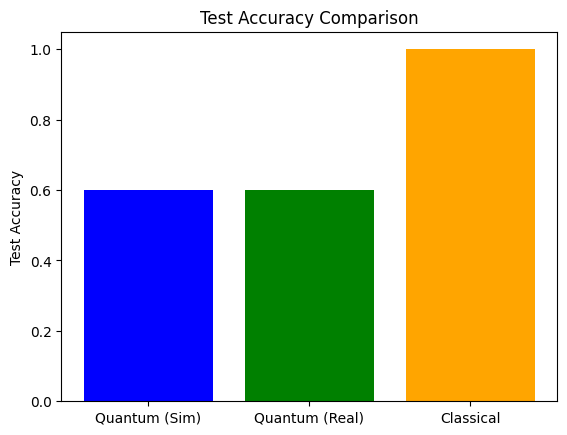

In [ ]:
# Plot training time comparison
labels = ['Quantum (Sim)', 'Quantum (Real)', 'Classical']
times = [quantum_time_sim, quantum_time_real, classical_time]

plt.bar(labels, times, color=['blue', 'green', 'orange'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()

# Plot accuracy comparison
scores = [qsvc_score_sim, qsvc_score_real, classical_score]

plt.bar(labels, scores, color=['blue', 'green', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()
